# **CMSC 320 Final Project** 
## **Group Members: Ricardo Vasquez, Justin Glazer, Jonathan Teagan, Colin Pollard**

## Table of Contents
1. Introduction
2. Data Curation
3. Exploratory Data Analysis
4. Primary Analysis
5. Visualization
6. Conclusions

## 1. Introduction
# Write Introduction Here

Contributions List:
1. **Colin Pollard:**  I helped with the data pre-processing, I did one of the statistic tests (proving ticket-class had an significant impact on passenger survival), and I helped visualize our data and findings by making graphs. I also helped with project formatting and implemented small changes/debugging throughout.
2. **Jonathan Teagan:** I helped by picking the data set and running early data cleaning including making new classes and dropping useless ones, these new classes were created using  previous existing variables and ingenuitive thinkign like using last names to create famlies.
3. **Justin Glazer:**
4. **Ricardo Vasquez:**


In [35]:
import pandas as pd
from datetime import datetime
import string
from scipy.stats import chi2_contingency, ttest_ind, spearmanr
import matplotlib.pyplot as plt
import sys
import numpy as np

## 2. Data Curation

In this section, we will discuss the dataset we are using for our analysis and transform it into a Pandas data frame.

### About the Dataset
For this project, we are using the Kaggle Titanic Dataset. The Titanic Dataset provides information about the passengers onboard the Titanic when it sank. This prominently includes their name, if they survived, the ticket class they were in, their ticket fare and other key demographic information.

This dataset was organized on Kaggle by M Yasser H and originally created by Thomas Cason and Michael A. Findlay. The Titanic Dataset has been used for numerous analyses and machine learning exercises, both in professional and educational contexts.

Dataset Citation:  
Yasser, M. H. (2021). Titanic Dataset (Version 1) [Data set]. Kaggle.  
https://www.kaggle.com/datasets/yasserh/titanic-dataset

### Data Preprocessing

**Creating the Dataframe**  
We are loading the dataset into Pandas through a CSV file.

In [36]:
titanic_df = pd.read_csv("Titanic-Dataset.csv")
rows_num, cols_num = titanic_df.shape
cols = titanic_df.columns.to_list()
col_types = titanic_df.dtypes.to_list()
info = titanic_df.count()
display(titanic_df.head(n=10), f"Rows: {rows_num}, Cols: {cols_num}", f"Column Names: {cols}", f"Column Types: {col_types}", info)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


'Rows: 891, Cols: 12'

"Column Names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']"

"Column Types: [dtype('int64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('O'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('float64'), dtype('O'), dtype('O')]"

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

**Analyzing the Data**

We start by checking to make sure all of the passanger IDs are unique so we do not have any collisions. We then check if we have any missing data that could potentially mess up our analysis in the future as well as if any of the string entries have any extraneous whitespace.

In [37]:
unique_id = titanic_df['PassengerId'].is_unique
tot_unique_id = titanic_df['PassengerId'].nunique()
print("PassengerId's Unique:", unique_id, ", Total Unique:",tot_unique_id, "out of", len(titanic_df))

null_count = titanic_df.isnull().sum()
duplicates = titanic_df.duplicated().sum()
print("Null counts by category:")
print(null_count)
print("Duplicated:", duplicates)


string_cols = titanic_df.select_dtypes(include=['object']).columns
for col in string_cols:
    whitespace_count = titanic_df[col].str.strip().ne(titanic_df[col]).sum()
    if whitespace_count > 0:
        print(col, ":",whitespace_count, "entries with leading/trailing whitespace")



PassengerId's Unique: True , Total Unique: 891 out of 891
Null counts by category:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Duplicated: 0
Name : 2 entries with leading/trailing whitespace
Cabin : 687 entries with leading/trailing whitespace
Embarked : 2 entries with leading/trailing whitespace


**Transforming the Data**

Here we are performing basic preprocessing of the data to prepare it for exploratory and later machine learning analysis. We start by removing the title from names and moving them to their own column. We then impute the missing age data with the mean. To compress the data even more, we combine the sibling, spouse, parent and children data into one column labeled family size. Furthermore, we use median imputation to fill in the missing fare data for each respective class. Finally, we add a column for family survival statistics and drop any unneccessary columns that will not be used for our analysis. 

In [38]:
# Extract titles from names
conditions = [
    titanic_df['Name'].str.contains('Mr.'),
    titanic_df['Name'].str.contains('Miss.'),
    titanic_df['Name'].str.contains('Master.'),
    ~(titanic_df['Name'].str.contains('Mr.|Miss.|Master.'))
]
values = ['Mr_and_Mrs', 'Miss', 'Master', 'Other']
titanic_df['Title'] = np.select(conditions, values, default='Other')

# Duplicate dataframe with rows having non-missing Age, for later analysis
stripped_df = titanic_df.copy().dropna(subset=['Age'])

# Impute missing Age values based on mean Age per Title
# Randomly drop some ages from titanic_df to simulate missing data for testing imputation methods, until size matches stripped_df
np.random.seed(42)  
ages_to_drop = titanic_df['Age'].dropna().sample(n=(len(titanic_df) - len(stripped_df)), random_state=42).index
titanic_df.loc[ages_to_drop, 'Age'] = np.nan
# Impute missing Age values based on mean Age per Title
titanic_df['Age'] = (
    titanic_df['Age']
    .fillna(titanic_df.groupby('Title')['Age'].transform('mean'))
)

# Reducing redundancy by combining SibSp and Parch into FamilySize
if 'SibSp' in titanic_df.columns and 'Parch' in titanic_df.columns:
    titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']
    titanic_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Same for stripped_df
if 'SibSp' in stripped_df.columns and 'Parch' in stripped_df.columns:
    stripped_df['FamilySize'] = stripped_df['SibSp'] + stripped_df['Parch']
    stripped_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Filling the missing Fare values based on median Fare per Pclass
if titanic_df['Fare'].isnull().sum() > 0:
    for pclass in titanic_df.loc[titanic_df['Fare'].isnull(), 'Pclass'].unique():
        median_fare = titanic_df.loc[titanic_df['Pclass'] == pclass, 'Fare'].median()
        titanic_df.loc[
            (titanic_df['Fare'].isnull()) & (titanic_df['Pclass'] == pclass),
            'Fare'
        ] = median_fare

if stripped_df['Fare'].isnull().sum() > 0:
    for pclass in stripped_df.loc[stripped_df['Fare'].isnull(), 'Pclass'].unique():
        median_fare = stripped_df.loc[stripped_df['Pclass'] == pclass, 'Fare'].median()
        stripped_df.loc[
            (stripped_df['Fare'].isnull()) & (stripped_df['Pclass'] == pclass),
            'Fare'
        ] = median_fare
        
# Using Dennis Bakhuis' Family Survival Feature Engineering Approach

def other_family_members_survived(dataset, label='family_survival'):
    """
    Checks whether other family members within the same surname or ticket survived.
    Returns a fractional indicator:
      - 1.0 if at least one other family member survived
      - 0.0 if no other family members survived
      - 0.5 if unknown (no family or missing data)
    """
    ds = dataset.copy()
    if len(ds) == 1:
        ds[label] = 0.5
        return ds

    result = []
    for idx, row in ds.iterrows():
        survived_fraction = ds.drop(idx)['Survived'].mean()
        if np.isnan(survived_fraction):
            result.append(0.5)
        elif survived_fraction == 0:
            result.append(0.0)
        else:
            result.append(1.0)
    ds[label] = result
    return ds

# Extract surname
titanic_df['surname'] = titanic_df['Name'].apply(lambda x: x.split(",")[0])
stripped_df['surname'] = stripped_df['Name'].apply(lambda x: x.split(",")[0])

# Apply family survival by surname + fare
titanic_df = (
    titanic_df.groupby(['surname'], group_keys=False)
    .apply(lambda g: other_family_members_survived(g), include_groups=False)
    .reset_index(drop=True)
)
stripped_df = (
    stripped_df.groupby(['surname'], group_keys=False)
    .apply(lambda g: other_family_members_survived(g), include_groups=False)
    .reset_index(drop=True)
)

# Apply family survival by ticket
titanic_df = (
    titanic_df.groupby(['Ticket'], group_keys=False)
    .apply(lambda g: other_family_members_survived(g, label='family_survival_ticket'), include_groups=False)
    .reset_index(drop=True)
)
stripped_df = (
    stripped_df.groupby(['Ticket'], group_keys=False)
    .apply(lambda g: other_family_members_survived(g, label='family_survival_ticket'), include_groups=False)
    .reset_index(drop=True)
)
# Replace unknowns (0.5) in surname-based feature with ticket-based info
mask = titanic_df['family_survival'] == 0.5
stripped_mask = stripped_df['family_survival'] == 0.5

titanic_df.loc[mask, 'family_survival'] = titanic_df.loc[mask, 'family_survival_ticket']
stripped_df.loc[stripped_mask, 'family_survival'] = stripped_df.loc[stripped_mask, 'family_survival_ticket']

# Dropping unneeded columns
cols_to_drop = ['Ticket', 'Cabin', 'PassengerId', 'family_survival_ticket']
titanic_df.drop(columns=[c for c in cols_to_drop if c in titanic_df.columns], inplace=True)
stripped_df.drop(columns=[c for c in cols_to_drop if c in stripped_df.columns], inplace=True)

# Printing Summaries
print("Preprocessing complete.")
print("\nTitanic DF Preview (Missing Age Based Off Mean):")
print("Shape:", titanic_df.shape)
print("Missing values per column:\n", titanic_df.isnull().sum())
print("\nPreview:")
print(titanic_df.head())
print("\nStripped DF Preview (Dropped Ages for Machine Learning Model):")
print("Shape:", stripped_df.shape)
print("Missing values per column:\n", stripped_df.isnull().sum())
print("\nPreview:")
print(stripped_df.head())


Preprocessing complete.

Titanic DF Preview (Missing Age Based Off Mean):
Shape: (891, 10)
Missing values per column:
 Survived           0
Pclass             0
Name               0
Sex                0
Age                0
Fare               0
Embarked           2
Title              0
FamilySize         0
family_survival    0
dtype: int64

Preview:
   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex        Age     Fare Embarked       Title  FamilySize  \
0    male  22.000000   7.2500        S  Mr_and_Mrs           1   
1  female  38.000000  71.2833        C  Mr_and_Mrs           1   
2  fe

The intresting part about cleaning the data set is that because of our practical knowledge we are able to construct further pieces of information about families or titles, and we can use that information to clean better such as filling in ages by titles, while some values were missing such as the many cabins we had to drop, this should not be a big issue as while location data could be valuable in determing links between survival and cabin, and the direct link between cabin and class, the link between class and survival is not only historically shown but is apparent with even a cursory viewing of the dataset.

## 3. Exploratory Data Analysis

### Conclusion 1

Is Sex correlated with Survival?

HO: The sex of the passanger does not affect if they survived.

HA: The sex of the passanger does affect if they survived.

$\alpha = 0.05$.

Survived,0,1
Sex,,
female,81,233
male,468,109


Chi-Squared P-Value: 1.1973570627755645e-58


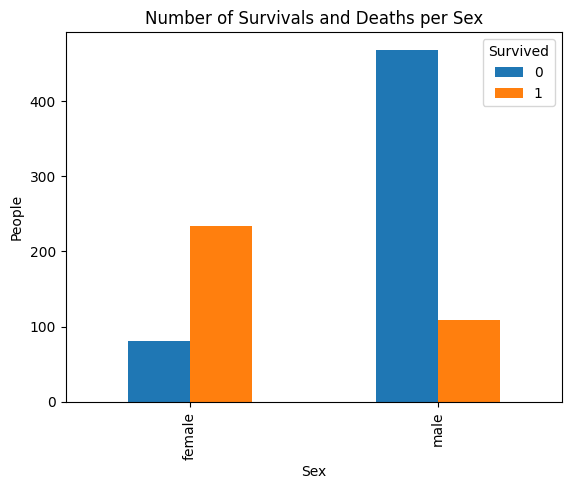

In [39]:
table = pd.crosstab(titanic_df['Sex'], titanic_df['Survived'])
display(table)
_, p_val, _, _ = chi2_contingency(table)
print(f"Chi-Squared P-Value: {p_val}")
table.plot(kind="bar")
plt.xlabel("Sex")
plt.ylabel("People")
plt.title("Number of Survivals and Deaths per Sex")
plt.show()


With a P-Value of 1.1973570627755645e-58 for the chi-squared test, this is clearly much less than the significance of 0.05. Thus, we reject the null hypothesis and find that there is a statistically significant correlation between sex and survival. This is further shown by the graph above which demonstrates women survived at a much higher rate than men. One cause of this could be the rule of "Women and Children First," leading to many men being unable to make it on a lifeboat.

### Conclusion 2

Is Age correlated with survival in Men?

HO: The age of the male passenger does not affect if they survived.

HA: The age of the male passenger does affect if they survived.

$\alpha = 0.05$.

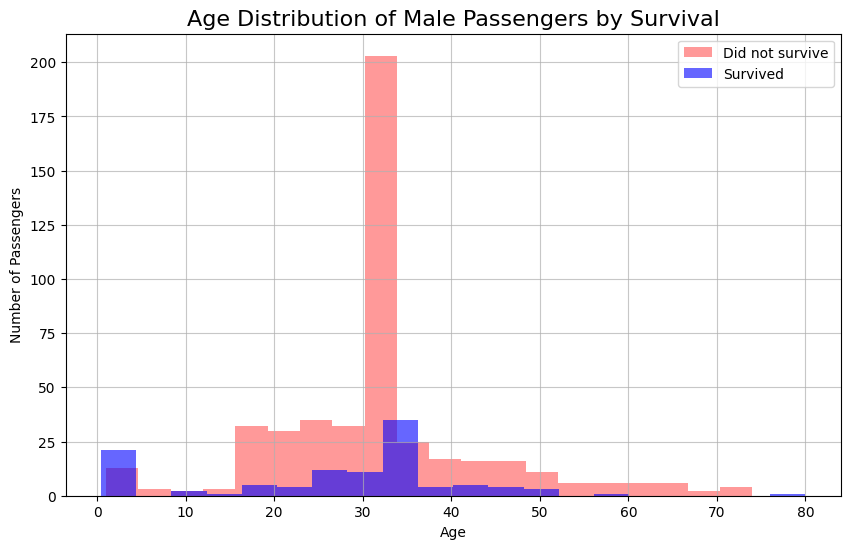

Average Age of Survivors: 27.2039 Average Std Dev of Survivors: 15.0931
Average Age of Non-Survivors: 32.6759 Average Std Dev of Non-Survivors: 11.8098
P-value: 0.0005


In [40]:
men = titanic_df[titanic_df['Sex'] == 'male']
men = men.dropna(subset=['Age'])

survivors = men[men["Survived"] == 1]["Age"]
nonsurvivors = men[men["Survived"] == 0]["Age"]
_, p_val = ttest_ind(survivors, nonsurvivors, equal_var=False)
plt.figure(figsize=(10,6))
plt.hist(nonsurvivors, bins=20, alpha=0.4, color="red", label="Did not survive")
plt.hist(survivors, bins=20, alpha=0.6, color="blue", label="Survived")
plt.title("Age Distribution of Male Passengers by Survival", fontsize=16)
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(alpha=0.7)
plt.show()

print("Average Age of Survivors:", round(survivors.mean(), 4), "Average Std Dev of Survivors:", round(survivors.std(), 4))
print("Average Age of Non-Survivors:", round(nonsurvivors.mean(), 4), "Average Std Dev of Non-Survivors:", round(nonsurvivors.std(), 4))
print(f"P-value: {p_val:.4f}")

The conducted T-test resulted in a p-value of 0.0092. Since our alpha value is 0.05 and our p-value is <= this alpha value, we reject the null hypothesis. This means that there is a statistically significant difference in average age between male survivors and non-survivors. This suggests that age is associated with survival among males. From the graph we can see younger males (ages 0-16) have a much higher survival rate than older males (ages 16-80). The graph representation also poses some new questions about the data set. Why might males ages 16-50 have survived? Did status or familiar ties play a role? If we follow the assumption of "women and children saved first," why are the number of adolescent male survivors and non-survivors fairly similar? Could it be chalked up to the harsh sea or does the data suggest something of significance?


### Conclusion 3

Is the Passengers' ticket classes correlated with their survival?

HO: Ticket class has no effect on the survival of the passengers.

HA: Ticket class has an effect on the survival of the passengers.

$\alpha = 0.05$



Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Chi-square test p-value: 4.549251711298793e-23


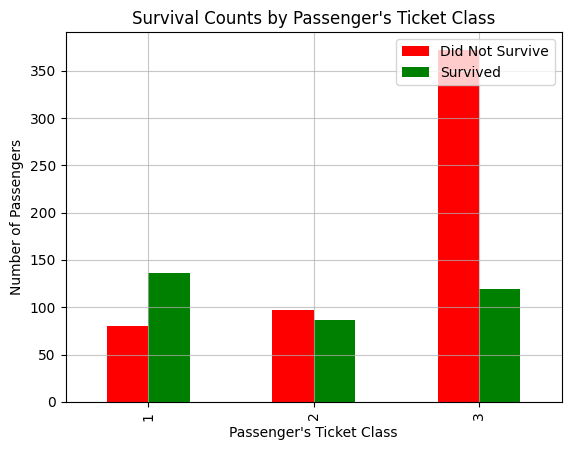

Survival Rates by Class:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


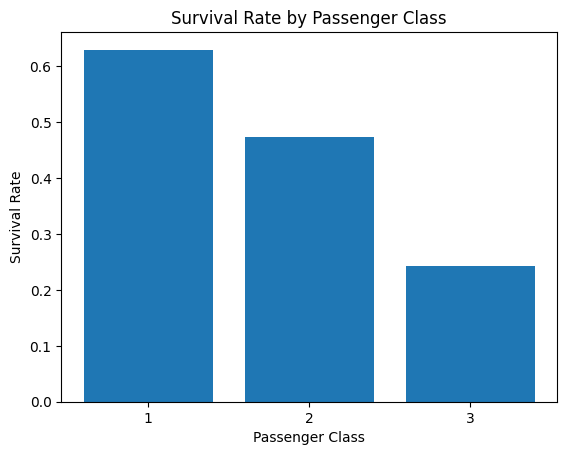

In [41]:
class_table = pd.crosstab(titanic_df['Pclass'], titanic_df['Survived'])
display(class_table)
_, p_val, _, _ = chi2_contingency(class_table)
print(f"Chi-square test p-value: {p_val}")

class_table.plot(kind="bar", stacked=False, color=["red", "green"])
plt.title("Survival Counts by Passenger's Ticket Class")
plt.xlabel("Passenger's Ticket Class")
plt.ylabel("Number of Passengers")
plt.legend(["Did Not Survive", "Survived"], loc="upper right")
plt.grid(alpha=0.7)
plt.show()

survival_rate_by_class = titanic_df.groupby("Pclass")["Survived"].mean()
print("Survival Rates by Class:")
print(survival_rate_by_class)

plt.bar(survival_rate_by_class.index.astype(str), survival_rate_by_class.values)
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()


As seen above, I executed a chi-square test to determine if there is a correlation between a passenger ticket class and passenger survival. The test yielded a p-value of 4.5493e-23, which is extremely small and far below the alpha value of 0.05. Thus passenger class and passenger survival are correlated.

The bar chart I created shows that first-class passengers had by far the highests rate of survival, and third-class passengers had by far the lowest rate of survival. This is likely due to both: the differing cabin locations of different ticket classes; and the differing levels of evacuation priority that comes with higher-class tickets.

### Conclusion 4

Is the Passengers' ticket fare correlated with their age?

HO: There is no relationship between ticket fare and age.

HA: There is a relationship between ticket fare and age.

$\alpha = 0.05$


SpearTest Pvalue: 0.025606086191833768
SpearTest Corr: 0.07477956899891634


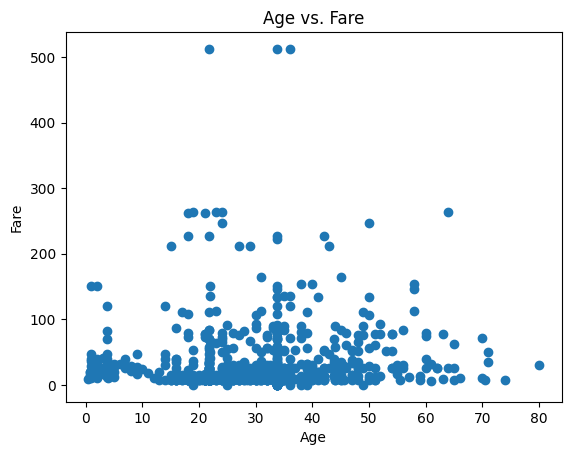

In [42]:
testSet = titanic_df[['Age', 'Fare']].dropna()
corr, pvalue = spearmanr(testSet['Age'], testSet['Fare'])
print(f"SpearTest Pvalue: {pvalue}")
print(f"SpearTest Corr: {corr}")
plt.scatter(titanic_df['Age'], titanic_df['Fare'])
plt.xlabel("Age")
plt.ylabel("Fare")
plt.title("Age vs. Fare")
plt.show()


As shown by the p-value less than 0.05, we reject the null and accept there is a relationship between age and ticket fare. However, based on the correlation coefficient and scatter plot, this relationship seems very weak.

## 4. Primary Machine Learning Analysis

4.1) Splitting Up the Data


In [43]:
# Split into the datasets into two each --> split into train/test for both datasets
from sklearn.model_selection import train_test_split

# Use stripped_df (only real ages)
X_stripped = stripped_df.drop('Survived', axis=1)
y_stripped = stripped_df['Survived']

# Use titanic_df (with imputed ages)
X_imputed = titanic_df.drop('Survived', axis=1)
y_imputed = titanic_df['Survived']

# Split first
X_stripped_train, X_stripped_test, y_stripped_train, y_stripped_test = train_test_split( X_stripped, y_stripped, test_size=0.2, random_state=42)
X_imputed_train, X_imputed_test, y_imputed_train, y_imputed_test = train_test_split( X_imputed, y_imputed, test_size=0.2, random_state=42)

4.2) Encoding and Training Models

In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_features(X_train, X_test):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    encoders = {}
    # Drop unique identifier columns that won't help prediction
    cols_to_drop = ['Name', 'surname']
    X_train_encoded = X_train_encoded.drop(columns=[c for c in cols_to_drop if c in X_train_encoded.columns])
    X_test_encoded = X_test_encoded.drop(columns=[c for c in cols_to_drop if c in X_test_encoded.columns])
    
    # Identify categorical columns
    categorical_cols = X_train_encoded.select_dtypes(include=['object']).columns
    
    # Encode each categorical column with handling for unseen labels
    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on train
        le.fit(X_train_encoded[col].astype(str))
        
        # Transform train
        X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
        
        # Transform test with handling for unseen categories
        # Map unseen categories to -1 (or most common class)
        test_values = X_test_encoded[col].astype(str)
        X_test_encoded[col] = test_values.map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        
        encoders[col] = le
    
    # Handle any remaining missing values in Embarked
    X_train_encoded = X_train_encoded.fillna(X_train_encoded.median())
    X_test_encoded = X_test_encoded.fillna(X_test_encoded.median())
    
    return X_train_encoded, X_test_encoded, encoders


def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name):
    print(f"Training With: {dataset_name}")
    # Preprocess
    X_train_enc, X_test_enc, encoders = preprocess_features(X_train, X_test)
    results = {}
    
    # Logistic Regression
    print("\n Logistic Regression")
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_enc, y_train)
    
    y_pred_lr = lr.predict(X_test_enc)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    
    print(f"  Accuracy: {acc_lr:.4f}")
    print("\n  Classification Report:")
    print(classification_report(y_test, y_pred_lr, target_names=['Died', 'Survived']))
    
    results['Logistic Regression'] = {
        'model': lr,
        'accuracy': acc_lr,
        'predictions': y_pred_lr,
        'y_test': y_test
    }
    
    # Random Forest
    print("\n Random Forest")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
    rf.fit(X_train_enc, y_train)
    
    y_pred_rf = rf.predict(X_test_enc)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    
    print(f"  Accuracy: {acc_rf:.4f}")
    print("\n  Classification Report:")
    print(classification_report(y_test, y_pred_rf, target_names=['Died', 'Survived']))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train_enc.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n Top 5 Most Important Features:")
    print(feature_importance.head())
    
    results['Random Forest'] = {
        'model': rf,
        'accuracy': acc_rf,
        'predictions': y_pred_rf,
        'y_test': y_test,
        'feature_importance': feature_importance
    }
    
    return results, X_train_enc, X_test_enc

print("Titanic Survival Prediction: Model Comparison")

# Train on stripped dataset (real ages only)
results_stripped, X_train_stripped_enc, X_test_stripped_enc = train_and_evaluate(
    X_stripped_train, X_stripped_test, 
    y_stripped_train, y_stripped_test,
    "Stripped Dataset (Real Ages Only)"
)

# Train on imputed dataset (mean imputed ages)
results_imputed, X_train_imputed_enc, X_test_imputed_enc = train_and_evaluate(
    X_imputed_train, X_imputed_test,
    y_imputed_train, y_imputed_test,
    "Imputed Dataset (Mean Imputed Ages)"
)

print("\n Final Comparison")
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'] * 2,
    'Dataset': ['Stripped'] * 2 + ['Imputed'] * 2,
    'Accuracy': [
        results_stripped['Logistic Regression']['accuracy'],
        results_stripped['Random Forest']['accuracy'],
        results_imputed['Logistic Regression']['accuracy'],
        results_imputed['Random Forest']['accuracy']
    ]
})

print("\n", comparison_df.to_string(index=False))

# Determine best model
best_idx = comparison_df['Accuracy'].idxmax()
best_row = comparison_df.iloc[best_idx]
print(f"\n Best Model: {best_row['Model']} on {best_row['Dataset']} dataset")
print(f"   Accuracy: {best_row['Accuracy']:.4f}")


Titanic Survival Prediction: Model Comparison
Training With: Stripped Dataset (Real Ages Only)

 Logistic Regression


  Accuracy: 0.7902

  Classification Report:
              precision    recall  f1-score   support

        Died       0.81      0.85      0.83        87
    Survived       0.75      0.70      0.72        56

    accuracy                           0.79       143
   macro avg       0.78      0.77      0.78       143
weighted avg       0.79      0.79      0.79       143


 Random Forest
  Accuracy: 0.8252

  Classification Report:
              precision    recall  f1-score   support

        Died       0.84      0.89      0.86        87
    Survived       0.80      0.73      0.77        56

    accuracy                           0.83       143
   macro avg       0.82      0.81      0.81       143
weighted avg       0.82      0.83      0.82       143


 Top 5 Most Important Features:
           feature  importance
1              Sex    0.386338
5            Title    0.127280
0           Pclass    0.122568
3             Fare    0.116571
7  family_survival    0.085695
Training With: Impute